# Show ggpointdensity vs binning

by Vito Zanotelli,
vito.zanotelli@gmail.com,
@ZanotelliVRT,
Zurich 2020

## Aim:
I want to show how to do high quality scatter plots when dealing with potentially millions of points in R.

This is motivated by this datashader tutorial, highlighting key pitfals when doing these kind of plots (https://datashader.org/user_guide/Plotting_Pitfalls.html).

Here I show how these challenges can be addressed by 2D binning in ggplot2 (R). The approach works equaly well in Python Matplotlib or plotnine and I can recommend it also there.
However, I also would highly recommend looking into Datashader when using Python (https://datashader.org).

Further I compare my approach to  `ggpointdensity`, as suggested to me by twitter (https://github.com/LKremer/ggpointdensity, https://twitter.com/jan_glx/status/1246751358604189697 ).

Another base R approach is `heatscatter` from `LSD`: https://www.rdocumentation.org/packages/LSD/versions/4.0-0/topics/heatscatter 


Finally I illustrate how the binning approach can be used to also map continuous features or class membership efficiently in such plots.


Note: Runtimes indicated are on my machine with 32 cores and 128 Gb ram.

In [1]:
# Change to FALSE if running this example on Binderhub, as otherwise the Kernel will crash
# If your run it on your own machine with >4GB run, consider setting this to TRUE.
IS_NOT_BINDER = TRUE

In [2]:
library(data.table) # Most performant data wrangling
library(ggpointdensity) # for geom_pointdensity
library(MASS) # for manual contours
library(tidyverse) # For ggplot2 and co
library(viridis) # Nice colormaps


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ dplyr::select()    masks MASS::select()
✖ purrr::transpose() masks data.table::transpose()
Loading required package: viridisLite


In [3]:
options(repr.plot.width=5, repr.plot.height=4)

First we reproduce the dataset from the Plotting Pitfalls example:


In [4]:
a_gaussian <- function(mnx, mny, sd, num){
    data.table(x=rnorm(num, mean=mnx, sd=sd), y=rnorm(num, mean=mny, sd=sd))
}

gaussians <- function(specs=list(c(1.5,0,1.0),c(-1.5,0,1.0)), num=100){
    set.seed(123)
    d = lapply(specs, function(s){a_gaussian(s[1], s[2], s[3], num)})
    d = rbindlist(d, idcol='g')
    d[, g:= as.factor(g)]
    d
}


This simulates 4 partially overlapping gaussians and samples 50'000 points each, so 250'000 total:

In [5]:
specs_5_pop <- list(c(2,2,0.02), c(2,-2,0.1), c(-2,-2,0.5), c(-2,2,1.0), c(0,0,3))
dists = gaussians(specs=specs_5_pop,num=50000)

Plotting the raw data shows that ggplot does not plot the points randomly - in this
sorted dataset this causes class 5 to overplott the others.


   user  system elapsed 
  2.960   0.104   3.153 

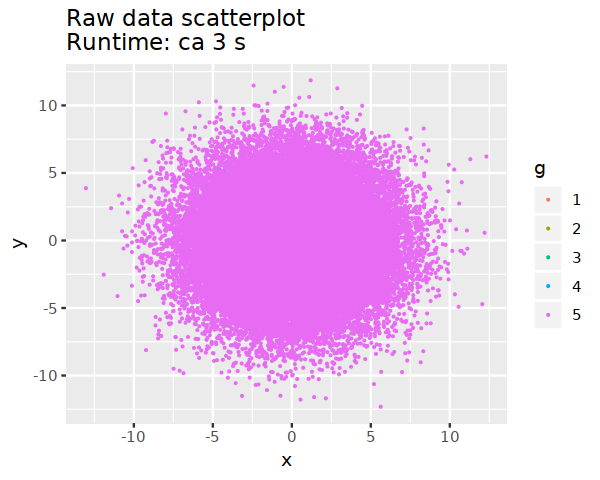

In [6]:
p <- ggplot(dists, aes(x=x, y=y, color=g))+
    geom_point(size=0.1)+
    ggtitle('Raw data scatterplot\nRuntime: ca 3 s')

system.time({print(p)})


Shuffling the data fixes this:

In [7]:
dists_shuffled <- dists[sample(nrow(dists)),]

   user  system elapsed 
  3.564   0.064   2.737 

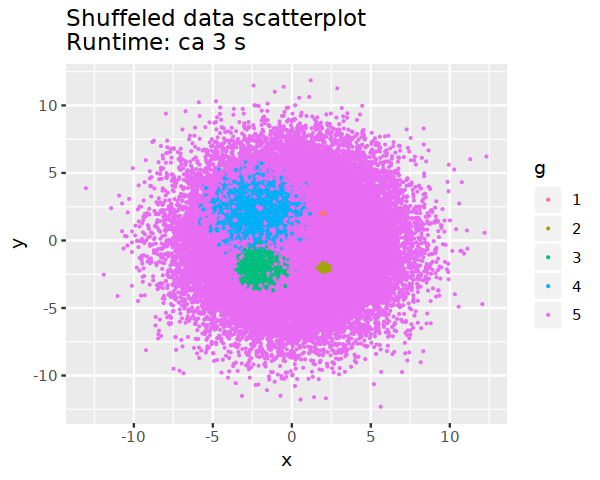

In [8]:
p <- ggplot(dists_shuffled, aes(x=x, y=y, color=g))+
    geom_point(size=0.1)+
    ggtitle('Shuffeled data scatterplot\nRuntime: ca 3 s')

system.time({print(p)})


## 2D bining aproach

My go-to approach for these kind plots is 2D binning the data.
The image is divided into a grid of bins x bins squares and the number of objects falling into the squares are counted.

Advantages:
- Fast and scalable:
    - Allows faster plotting iterations
    - Doesnt plot individual overlapping points
    - Calculating counts is a linear function of the number of points. Thus this scales to millions (or 100 millions) of points.
- Single, separated points still visible
- No additional dependencies

Disadvantages:
- Hard to identify individual points interactively
- Manual choice of bins -> I recommend to choose so many bins that individual points just visible at screen resolution

Neutral
- Hard bining - no constraints on smootheness: This reports exactly how many points fall into each bin, no smoothness is assumed. Approaches that assume smoothness might be advantagous in cases

Comment: solutions like datashader pretty much solve all these issues, by choose the binsize dynamically. In datashader bins are automatically choosen according to output resolution, eg allowing to zoom in, until all points are individually visible. But datashader only exists for R - as far as I know.

Further this works as well with the geom_hexbin - I just happen to like squares better :)

Additionally one can also plot the bins as points, to get a more 'scatterplot' like look.


   user  system elapsed 
  0.668   0.004   0.674 

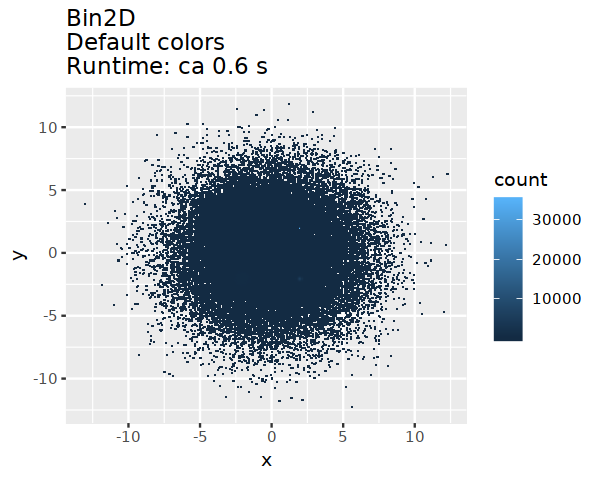

In [9]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    geom_bin2d(bins=300)+
    ggtitle('Bin2D\nDefault colors\nRuntime: ca 0.6 s')

system.time({print(p)})


Also choosing a good colormap and transforming counts is key.

   user  system elapsed 
  0.600   0.008   0.609 

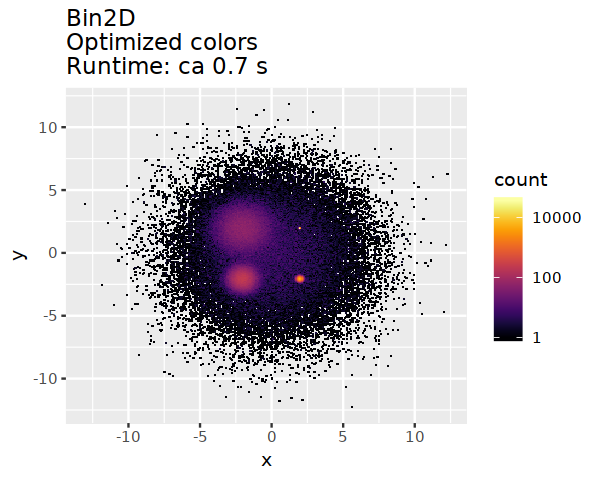

In [10]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    geom_bin2d(bins=300)+
    scale_fill_viridis(trans = "log10", option='inferno')+
    ggtitle('Bin2D\nOptimized colors\nRuntime: ca 0.7 s')

system.time({print(p)})



It is also possible to 'fake' individual points using this strategy.
This has still the advantage of avoiding overplotting:


   user  system elapsed 
  0.924   0.004   0.759 

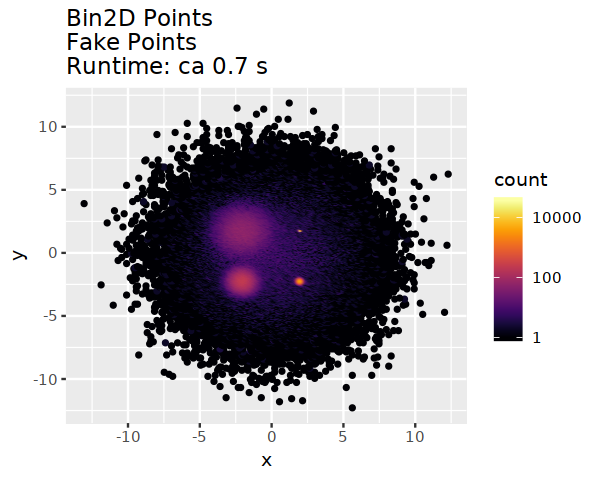

In [11]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    stat_bin2d(aes(color=..count..), bins=300, geom='point', size=1, fill=1)+
    scale_color_viridis(trans = "log10", option='inferno')+
    ggtitle('Bin2D Points\nFake Points\nRuntime: ca 0.7 s')

system.time({print(p)})


This visualization is now really almost equivalent to the `geom_pointdensity` - but way faster
and better scaling.

Bins can be used to make the integration coarser or finer.


   user  system elapsed 
  1.188   0.028   0.430 

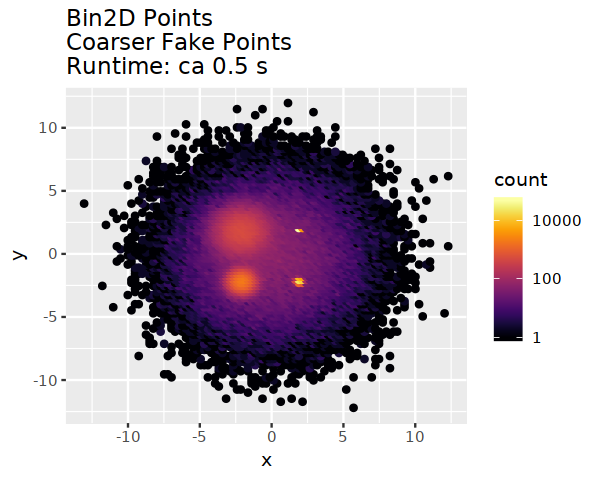

In [12]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    stat_bin2d(aes(color=..count..), bins=100, geom='point', size=1.4, fill=1)+
    scale_color_viridis(trans = "log10", option='inferno')+
    ggtitle('Bin2D Points\nCoarser Fake Points\nRuntime: ca 0.5 s')

system.time({print(p)})



Whenever bin2d is uese, also geom_hexbin can be used:

   user  system elapsed 
  1.420   0.020   0.661 

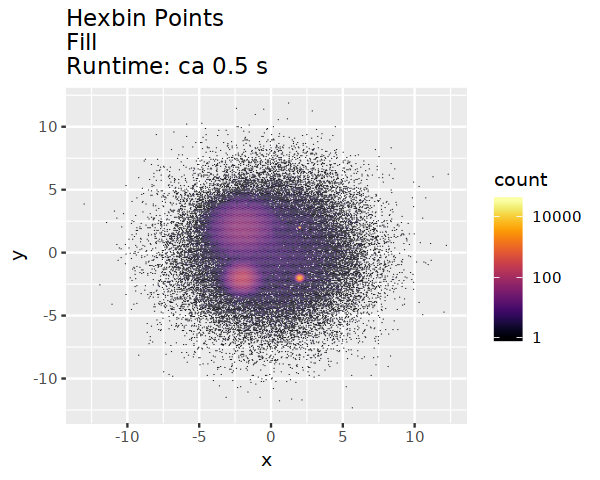

In [13]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    geom_hex(bins=300)+
    scale_fill_viridis(trans = "log10", option='inferno')+
    ggtitle('Hexbin Points\nFill\nRuntime: ca 0.5 s')

system.time({print(p)})



Here I find this much nicer looking when mapping the 'color' instead of 'fill':


   user  system elapsed 
  2.108   0.068   0.754 

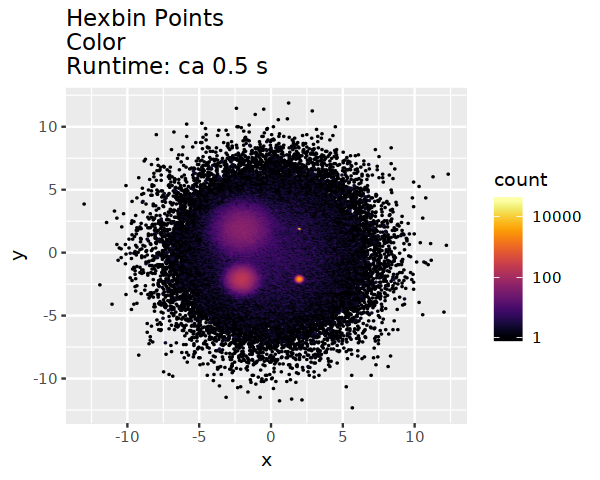

In [14]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    geom_hex(aes(color=..count..),bins=300, fill=1)+
    scale_color_viridis(trans = "log10", option='inferno')+
    ggtitle('Hexbin Points\nColor\nRuntime: ca 0.5 s')

system.time({print(p)})



The bin2d approach also scales nicely with more points:
Here 5 Mio points


   user  system elapsed 
  7.520   2.044   7.860 

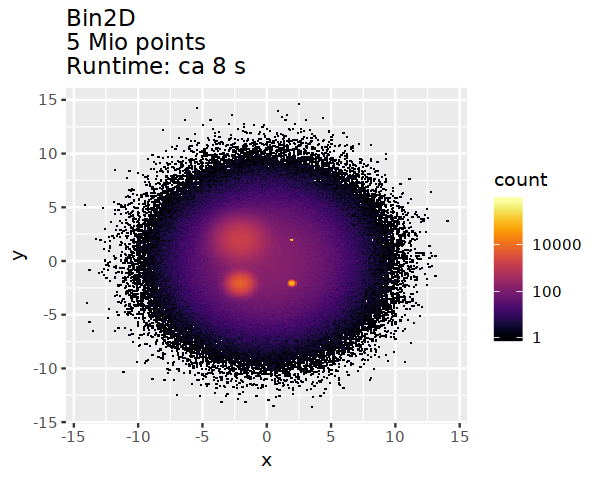

In [15]:
dists2 <- gaussians(specs=specs_5_pop,num=1000000)

p <- ggplot(dists2, aes(x=x, y=y))+
    stat_bin2d(bins=300)+
    scale_fill_viridis( name = "count", trans = "log10", option='inferno')+
    ggtitle('Bin2D\n5 Mio points\nRuntime: ca 8 s')

system.time({print(p)})


or 50 Mio points.

The datashader tutorial claims this to be more than most plotting programs can handle:
https://datashader.org/user_guide/Plotting_Pitfalls.html

With the bin2d approach all populations are still well visible without adjusting any parameters:
From 5 to 50 Mio points runtime scales approximately linearly, as expected.

** Note: This uses >4Gb of Ram and thus cannot be run on Binder ** 

   user  system elapsed 
 53.680  26.520  80.208 

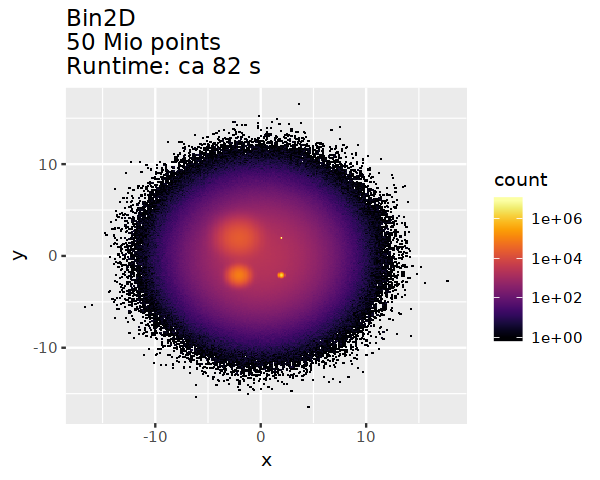

In [16]:
if (IS_NOT_BINDER){
    dists2 <- gaussians(specs=specs_5_pop,num=10000000)

    p <- ggplot(dists2, aes(x=x, y=y))+
        stat_bin2d(bins=300)+
        scale_fill_viridis( name = "count", trans = "log10", option='inferno')+
        ggtitle('Bin2D\n50 Mio points\nRuntime: ca 82 s')

    system.time({print(p)})
}



## geom pointdensity approach:

This plots for each point the number of neighbours in a range (smoothing bandwidth).

Advantages:
- Single points visible & still individual objects
- Density visible

Disadvantages:
- Slow
- Mapping of group/value variables?

Neutral:
- Counts interpretation: here a count means 'number of neighbours within a small radius' not number of cells exactly at this location.

This is quite slow for two reasons:
- Given that these needs consider all neighbours between all points this is a rather intensive computation and correspondingly quite slow.
    - Potential solutions: the runtime could be optimized by using different (approximate) neighbour algorithms or density estimation methods.

- It plots all points individually - plotting n points will result in n objects in your plot, even if most of them are overplotting and covering each other:
  - Potential solutions: identify overlapping points and dont plot them.
    
Parameters to consider for this:
- size: size of the points, the bigger the more overplotting
- adjust: bandwidth where objects are considered neighbours . The bigger ths smoother the denisty estimate.


Warning message:
“Ignoring unknown parameters: method”

   user  system elapsed 
 58.640   0.000  58.639 

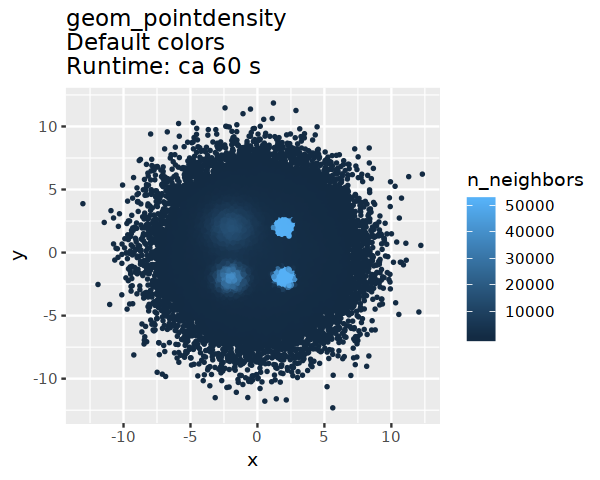

In [17]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    geom_pointdensity(size=0.5, adjust=1, method="default")+
    ggtitle('geom_pointdensity\nDefault colors\nRuntime: ca 60 s')

system.time({print(p)})


The default plot can be substantially visually improved by using a nonlinear, perceptually uniform colormap and log-transforming the counts.


   user  system elapsed 
 58.752   0.000  58.664 

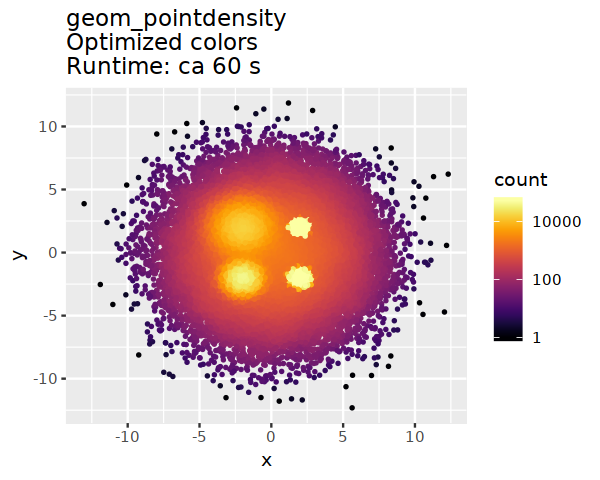

In [18]:
p <- p + scale_color_viridis( name = "count", trans = "log10", option='inferno')+
    ggtitle('geom_pointdensity\nOptimized colors\nRuntime: ca 60 s')
system.time({print(p)})


In summary the geom_pointdensity approach seems to be ca 2 orders of magnitude slower.

Would be also some further tuning needed:
- saturation at small cluster
    - consider different bandwith
    - consider modifying colormap to better cover the dynamic range

There seems also to be a new KDE 2D method for geom_pointscatter, that will become the default.

Note: This works only with the github version of the package. As I want to stick to conda I wont demonstrate this here.

Playing around this is indeed ca 10x faster, but still much slower than binning.


Warning message:
“Ignoring unknown parameters: method”

   user  system elapsed 
 58.520   0.000  58.371 

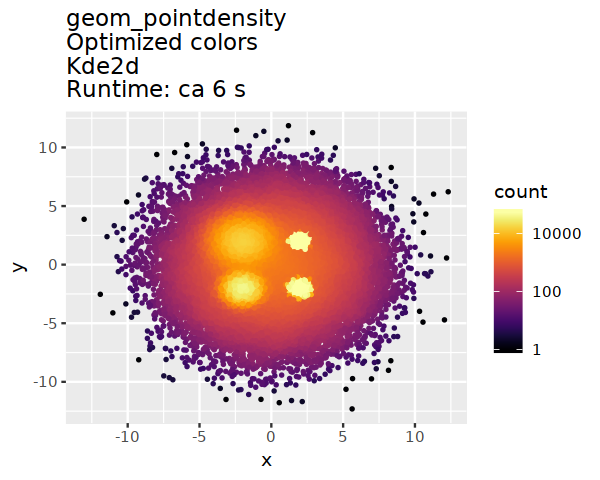

In [19]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    geom_pointdensity(size=0.5, adjust=1, method='kde2d')+
    scale_color_viridis( name = "count", trans = "log10", option='inferno')+
    ggtitle('geom_pointdensity\nOptimized colors\nKde2d\nRuntime: ca 6 s')
system.time({print(p)})


Maybe rasterizing the points can help:
(This requires ggrastr)

Loading required package: ggrastr
Warning message:
“Ignoring unknown parameters: method”

   user  system elapsed 
 64.012   0.000  63.974 

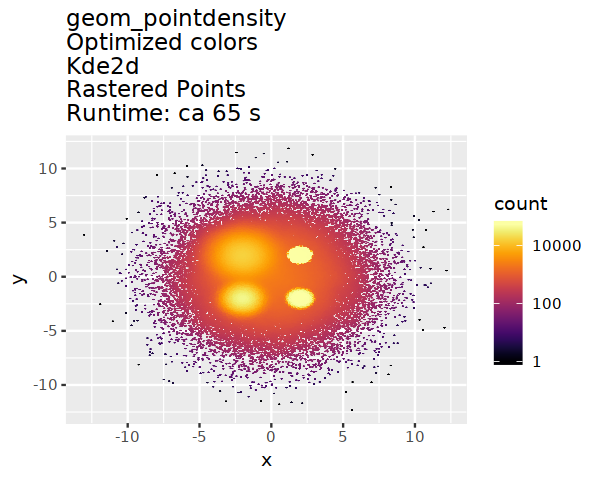

In [20]:
if (require('ggrastr')){
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    stat_pointdensity(size=0.5, adjust=1, method='kde2d', geom = ggrastr:::GeomPointRast)+
    scale_color_viridis( name = "count", trans = "log10", option='inferno')+
    ggtitle('geom_pointdensity\nOptimized colors\nKde2d\nRastered Points\nRuntime: ca 65 s')
system.time({print(p)})
}

Even a bit slower.

In sum, I personally prefer 2D binning for the superior speed.

Still, if real single points are required (eg for interactivity), geom_pointdensity is the way to go.

## Plotting groups/averages

Here I want to quickly illustrate how one can also visualize multiple groups/average values using a bining approach.

The key challenge is working around overplotting.

There are two approaches based on aggregating:
    - an aggregated value (eg mean) per bin -> smooth, but might hide local variability
    - a random value of the bin -> most similar to a scatterplot, hides local variability less.

To highlight groups, facetgriding the plot can also be a good way.


In [21]:
# Some helper functions used below
precompute_contour <- function(x, y, n=50, ...){
    # Precomputes and tidies the contour
    res = kde2d(x,y, n, ...)
    
    colnames(res[[3]]) = res[[2]]
    tdat = as.data.table(res[[3]])
    tdat[, x:= res[[1]]]
    tdat = melt.data.table(tdat, id.vars = 'x',variable.name = 'y', value.name = 'z')
    tdat[, y:= as.numeric(as.character(y))]
    return(tdat)
}


repeat_groups <- function(dat, grp_levels, grp_name){
    # Repeats a dataframe along a grouping factor
    dat_out <- rbindlist(lapply(grp_levels, function(x) dat), idcol=grp_name)
    dat_out[, g:= factor(g, levels=grp_levels)]
    dat_out
}
                                
sample_one <- function(x){
    # Helper function to sample exactly 1 element
    if (length(x) == 0){
        return(NA)
    } else if (length(x) == 1){
        return(x)
    } else {
        return(sample(x, 1))
    }
}

get_first <- function(x){
    # Helper function to get first element or return na
    if (length(x) == 0){
        return(NA)
    }
    return(x[1])
}

As a toy example I calculate the some random value directly from the label:

In [22]:
dists[, value :=(as.numeric(g)+rnorm(.N, 0,1))]

# again a shuffled version
dists_shuffled <- dists[sample(nrow(dists)),]

This is how the average bin value would look like. This represents the local average of the value:

   user  system elapsed 
  1.180   0.000   1.183 

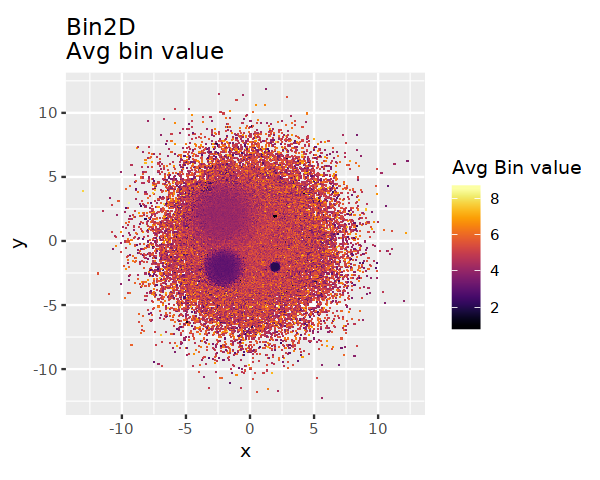

In [23]:
p <- ggplot(dists, aes(x=x, y=y))+
    stat_summary_2d(aes(z=value),bins=300, fun='mean')+
    scale_fill_viridis( name = "Avg Bin value", option='inferno')+
    coord_fixed()+
    ggtitle('Bin2D\nAvg bin value')
system.time({print(p)})

And this how taking a random pointvalue per bin shows more data variability:

   user  system elapsed 
  2.008   0.016   1.595 

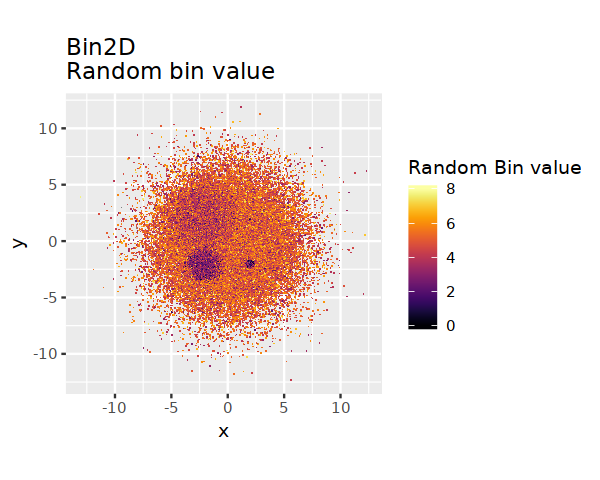

In [24]:
p <- ggplot(dists, aes(x=x, y=y))+
    stat_summary_2d(aes(z=value),bins=500, fun=sample_one)+
    scale_fill_viridis( name = "Random Bin value", option='inferno',
                        limits=c(0,8) # limits added to improve comparibility with other scatterplots, not necessary
                       )+
    coord_fixed()+
    ggtitle('Bin2D\nRandom bin value')
system.time({print(p)})

Again one could use points to plot the bins, to get a more scatterplot like apearance:

   user  system elapsed 
  1.840   0.000   1.811 

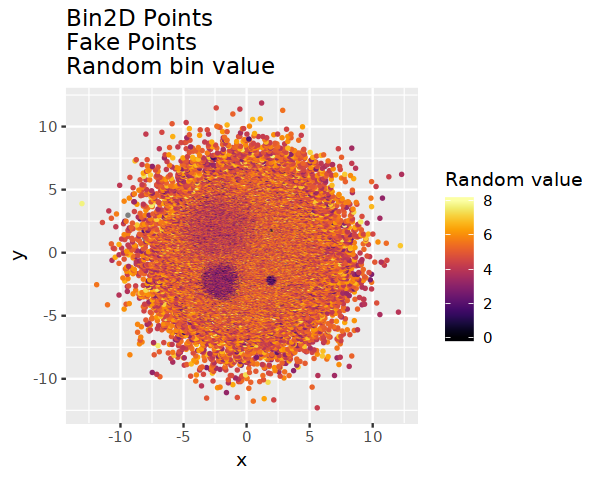

In [25]:
p <- ggplot(dists, aes(x=x, y=y))+
    stat_summary_2d(aes(z=value, color=stat(value)),bins=500,fun=sample_one, geom='point', fill=1,size=0.5)+
    scale_color_viridis( name = "Random value", option='inferno',
                        limits=c(0,8) # limits added to improve comparibility with other scatterplots, not necessary
                       )+
    coord_fixed()+
    ggtitle('Bin2D Points\nFake Points\nRandom bin value')
system.time({print(p)})


Again stat_hexbin could be used as well:

   user  system elapsed 
  1.204   0.000   1.197 

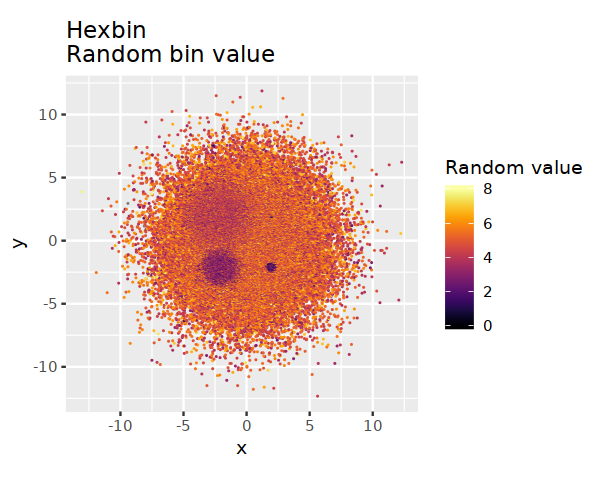

In [26]:
p <- ggplot(dists, aes(x=x, y=y))+
    stat_summary_hex(aes(z=value, color=stat(value)),bins=500,fun=sample_one, fill=1)+
    scale_color_viridis( name = "Random value", option='inferno',
                        limits=c(0,8) # limits added to improve comparibility with other scatterplots, not necessary
                       )+
    coord_fixed()+
    ggtitle('Hexbin\nRandom bin value')
system.time({print(p)})


When using the shuffeled version, this can be (slightly faster) achieved by just taking the first element every time.
This avoids sampling as the data is already shuffled.

   user  system elapsed 
  1.540   0.024   1.137 

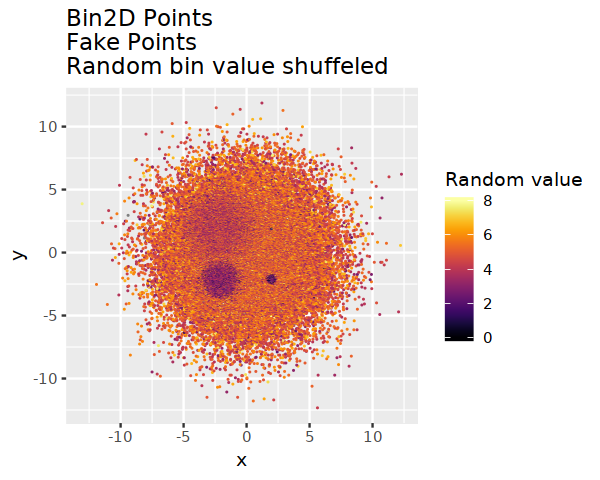

In [27]:
p <- ggplot(dists_shuffled, aes(x=x, y=y))+
    stat_summary_hex(aes(z=value, color=stat(value)),bins=500,fun=get_first, fill=1)+
    scale_color_viridis( name = "Random value", option='inferno',
                        limits=c(0,8) # limits added to improve comparibility with other scatterplots, not necessary
                       )+
    coord_fixed()+
    ggtitle('Bin2D Points\nFake Points\nRandom bin value shuffeled')
system.time({print(p)})


As a comparison: how does this look with a 'real' scatterplot:


   user  system elapsed 
  2.920   0.008   2.756 

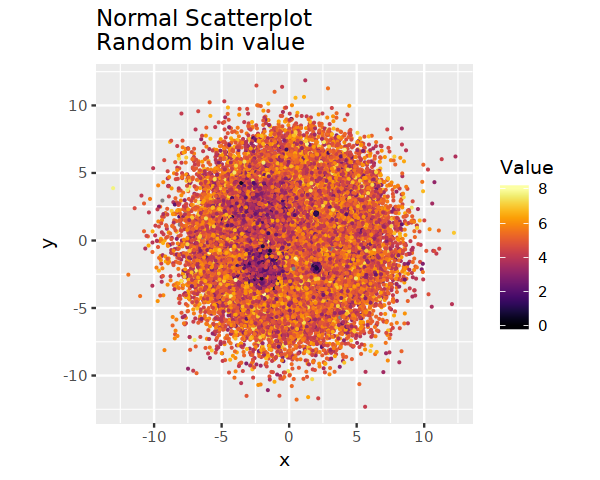

In [28]:
p <- ggplot(dists[sample(1:nrow(dists)),], aes(x=x, y=y))+
    geom_point(aes(color=value), size=0.1)+
    scale_color_viridis( name = "Value", option='inferno',
                        limits=c(0,8) # limits added to improve comparibility with random value binplot
                        )+
    coord_fixed()+
    ggtitle('Normal Scatterplot\nRandom bin value')
system.time({print(p)})


A main difference between the faked, binned scatterplot and the true scatterplot is
that the faked plot is more 'mixed' in the overplotted region, while a real scatterplot is more coarse.

This is because of the random plotting order in the real scatterplot and a plotting sorted by X,Y in the
bin2d scatterplot. Plotting it sorted in this case makes all points slighly visible as they are all plotted with a small offset. This leads to the 'mixed' visuals.

In my opinion, the distributions are better visible in the 'fake' scatterplot.

#### An alternaive is to use facetting to emphasize groups:

I like to add a contour of the overall data as a visual orientation.

Calculate contour:


In [29]:
dat_contour <- precompute_contour(dists$x, dists$y, n=100, h=2) %>%
                repeat_groups(levels(dists$g), 'g')




Show density facet gridded:

   user  system elapsed 
  1.012   0.000   1.013 

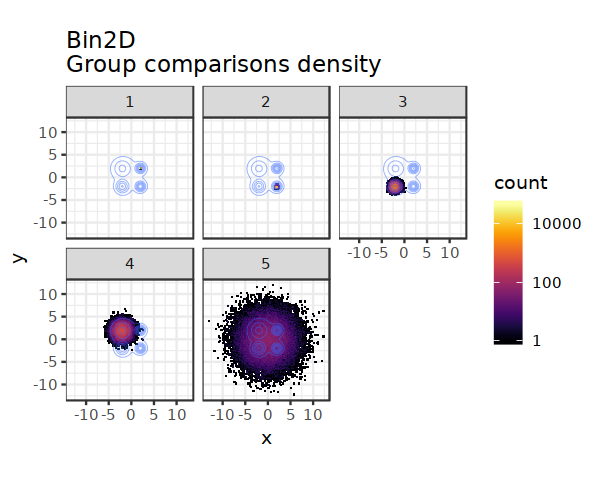

In [30]:
p <- ggplot(dists, aes(x=x, y=y))+
    facet_wrap('g')+
    stat_bin2d(bins=100)+
    scale_fill_viridis( name = "count", trans = "log10", option='inferno')+
    geom_contour(aes(z=sqrt(z)), data= dat_contour,size=0.2, alpha=0.5)+
    coord_fixed()+
    ggtitle('Bin2D\nGroup comparisons density')+
    theme_bw()
    

system.time({print(p)})

Show group label gridded:

   user  system elapsed 
  1.228   0.000   1.232 

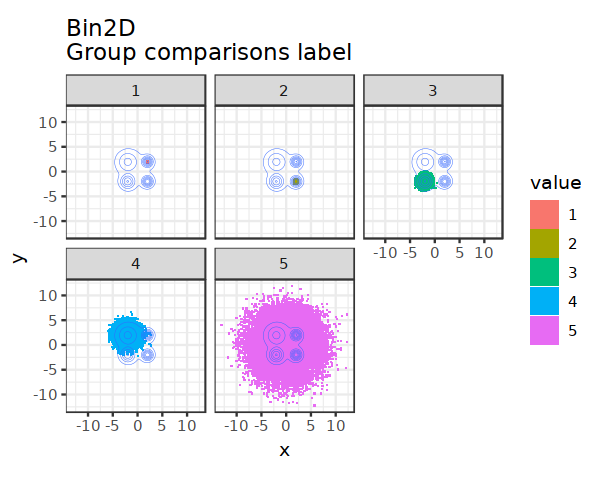

In [31]:
p <- ggplot(dists, aes(x=x, y=y))+
    facet_wrap('g')+
    stat_summary_2d(aes(z=g),bins=100, fun=sample_one)+
    geom_contour(aes(z=sqrt(z)), data=dat_contour,size=0.1)+
    coord_fixed()+ggtitle('Bin2D\nGroup comparisons label')+
    theme_bw()
system.time({print(p)})

Show markers gridded:

   user  system elapsed 
  2.536   0.000   2.536 

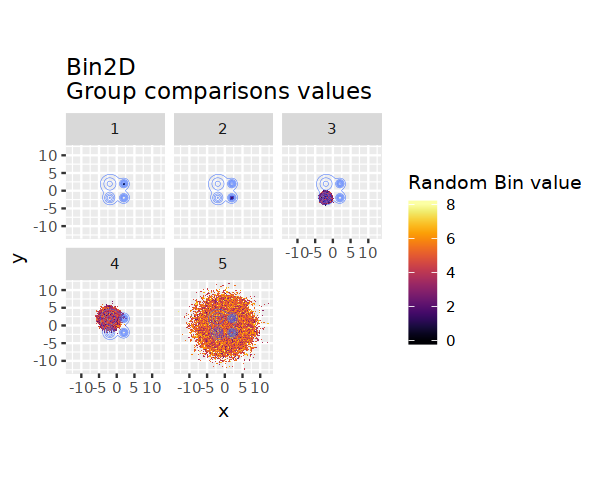

In [32]:
p <- ggplot(dists, aes(x=x, y=y))+
    facet_wrap('g')+
    stat_summary_2d(aes(z=value),bins=500, fun=sample_one)+

    scale_fill_viridis( name = "Random Bin value", option='inferno',
                        limits=c(0,8) # limits added to improve comparibility with other scatterplots, not necessary
                       )+
    geom_contour(aes(z=sqrt(z)), data=dat_contour,size=0.1)+
    coord_fixed()+
    ggtitle('Bin2D\nGroup comparisons values')
system.time({print(p)})

### Addendum:

One could also plot a random group label per bin. This should still show where the groups are located.

Strangely this doesnt work using my code and I cannot find how I solved this before. The reason is that `stat_summary_2d` automatically groups the data is `z` is a factor.

Does somebody know a good solution for this?


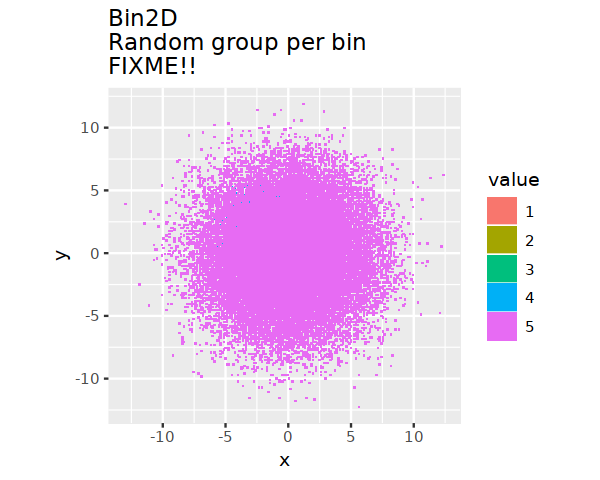

In [33]:
p <- ggplot(dists, aes(x=x, y=y))+
    stat_summary_2d(aes(z=g),bins=200, fun=sample_one)+
    scale_fill_discrete()+
    coord_fixed()+
    ggtitle('Bin2D\nRandom group per bin\nFIXME!!')
p


This leads to duplicates and overplotting

Smalll research into the ggplot data:

In [34]:
d = ggplot_build(p)

dat =d$data[[1]]

nrow(dat)

head(dat[duplicated(dat[, c('x','y')]),])


[1] 14729

,fill,xbin,ybin,value,x,y,z,PANEL,group,xmin,xmax,ymin,ymax,colour,size,linetype,alpha,width,height
756,#00B0F6,81,86,4,-2.851807,-1.994025,4,1,4,-2.915180,-2.788433,-2.05445,-1.93360,NA,0.1,1,NA,NA,NA
757,#00B0F6,82,86,4,-2.725060,-1.994025,4,1,4,-2.788433,-2.661686,-2.05445,-1.93360,NA,0.1,1,NA,NA,NA
758,#00B0F6,92,86,4,-1.457590,-1.994025,4,1,4,-1.520964,-1.394217,-2.05445,-1.93360,NA,0.1,1,NA,NA,NA
759,#00B0F6,77,87,4,-3.358795,-1.873175,4,1,4,-3.422168,-3.295421,-1.93360,-1.81275,NA,0.1,1,NA,NA,NA
760,#00B0F6,87,88,4,-2.091325,-1.752325,4,1,4,-2.154699,-2.027952,-1.81275,-1.69190,NA,0.1,1,NA,NA,NA
761,#00B0F6,88,88,4,-1.964578,-1.752325,4,1,4,-2.027952,-1.901205,-1.81275,-1.69190,NA,0.1,1,NA,NA,NA


Manually forcing the group does also not work, as in this case the output is coerced to numeric again


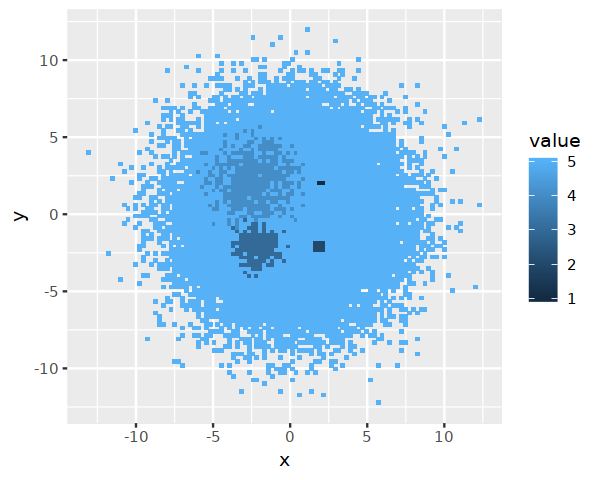

In [35]:
p <- ggplot(dists, aes(x=x, y=y))+
    stat_summary_2d(aes(z=g, group=1),bins=100, fun=sample_one)+
    coord_fixed()
p


That's it! Let me know on Github or Twitter if you have any comments/questions.

In [36]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/vitoz/miniconda3/envs/heatscatter2/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_CH.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_CH.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_CH.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_CH.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrastr_0.1.7        hexbin_1.27.2        viridis_0.5.1       
 [4] viridisLite_0.3.0    forcats_0.4.0        stringr_1.4.0       
 [7] dplyr_0.8.0.1        purrr_0.3.2          readr_1.3.1         
[10] tidyr_0.8.3          tibble_2.1.1         ggplot2_3.1.1       
[13] tidyverse_1.2.1   